In [1]:
import sys
from pathlib import Path

# Get the parent directory of the notebooks folder
project_root = Path.cwd().parent

# Add the src folder to sys.path
sys.path.append(str(project_root / "src"))

from d2l import torch as d2l
import random
import torch
%matplotlib inline
# self-defined functions
from utilities import add_to_class



## Synthetic Data


In [2]:
num_train=1000
num_val=1000
batch_size=32
noise = 0.01
w=torch.tensor([2, -3.4])
b=4.2

n = num_train + num_val
X = torch.randn(n, len(w))
noise = torch.randn(n, 1) * noise
y = torch.matmul(X, w.reshape((-1, 1))) + b + noise

In [3]:
from data import SyntheticRegressionData

data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)


/opt/miniconda3/envs/d2l/bin/python


In [4]:
# @add_to_class(SyntheticRegressionData)
# def get_dataloader(self, train):
#     """
#     Generate a data loader for training or validation.

#     Args:
#         train (bool): Whether to generate a data loader for training. If False, generate a data loader for validation.

#     Yields:
#         tuple: A tuple containing a batch of input data and a batch of output data.
#     """
#     # If it is a training data loader, generate a list of indices from 0 to num_train-1
#     if train:
#         indices = list(range(0, self.num_train))
#         # The examples are read in random order
#         random.shuffle(indices)
#     # If it is a validation data loader, generate a list of indices from num_train to num_train+num_val-1
#     else:
#         indices = list(range(self.num_train, self.num_train+self.num_val))
#     # Iterate over the indices in steps of batch_size
#     for i in range(0, len(indices), self.batch_size):
#         # Generate a batch of indices
#         batch_indices = torch.tensor(indices[i: i+self.batch_size])
#         # Yield a batch of input data and a batch of output data
#         yield self.X[batch_indices], self.y[batch_indices]

print(vars(data).keys())

dict_keys(['hparams', 'root', 'num_workers', 'w', 'b', 'noise', 'num_train', 'num_val', 'batch_size', 'X', 'y'])


In [5]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


## Use Torch API for Synthetic Data

In [6]:
# @add_to_class(d2l.DataModule)  #@save
# def get_tensorloader(self, tensors, train, indices=slice(0, None)):
#     """
#     Create a data loader from a tuple of tensors.

#     Args:
#         tensors (tuple): A tuple of tensors.
#         train (bool): Whether the data loader is for training.
#         indices (slice): A slice object indicating which indices to use.

#     Returns:
#         DataLoader: A PyTorch DataLoader object.
#     """
#     # Slice each tensor in the tuple using the given indices
#     tensors = tuple(a[indices] for a in tensors)
#     # Create a TensorDataset from the sliced tensors
#     dataset = torch.utils.data.TensorDataset(*tensors)
#     # Create and return a DataLoader from the dataset
#     return torch.utils.data.DataLoader(dataset, self.batch_size,
#                                        shuffle=train)


# @add_to_class(SyntheticRegressionData)  #@save
# def get_dataloader(self, train):
#     i = slice(0, self.num_train) if train else slice(self.num_train, None)
#     return self.get_tensorloader((self.X, self.y), train, i)

In [7]:
# test
num_train = 10
indices = slice(0, 3) 
tensors = (X, y)
tensors = tuple(a[indices] for a in tensors)
print(tensors)
print(*tensors)

(tensor([[-0.3014,  0.4420],
        [ 1.0599,  0.7399],
        [ 0.6163,  0.6728]]), tensor([[2.0927],
        [3.8025],
        [3.1405]]))
tensor([[-0.3014,  0.4420],
        [ 1.0599,  0.7399],
        [ 0.6163,  0.6728]]) tensor([[2.0927],
        [3.8025],
        [3.1405]])


In [8]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


## Linear Regression

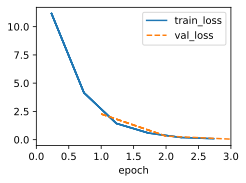

In [9]:
from models import LinearRegressionScratch, Trainer, LinearRegression

model = LinearRegressionScratch(2, lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)

error in estimating w: tensor([ 0.0078, -0.0076])
error in estimating b: tensor([0.0130])


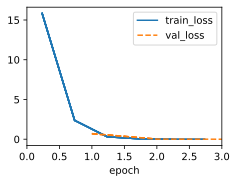

In [10]:
model = LinearRegression(lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)

@add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

#### Implemented in Procedure Code

Epoch 1, Training Loss: 7.5115, Validation Loss: 2.4294
Epoch 2, Training Loss: 1.0868, Validation Loss: 0.3459
Epoch 3, Training Loss: 0.1553, Validation Loss: 0.0469


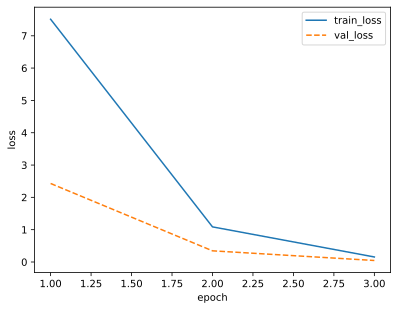

In [11]:
import torch
import random
import matplotlib.pyplot as plt

# Function to generate synthetic data for linear regression
# w: true weights, b: true bias, noise: standard deviation of noise
# num_train: number of training examples, num_val: number of validation examples
def generate_synthetic_data(w, b, noise=0.01, num_train=1000, num_val=1000):
    n = num_train + num_val
    # Generate random features
    X = torch.randn(n, len(w))
    # Add Gaussian noise to the labels
    noise = torch.randn(n, 1) * noise
    # Linear model with added noise
    y = torch.matmul(X, w.reshape((-1, 1))) + b + noise
    return X, y, num_train, num_val

# Function to create a data loader that yields batches of data
# train: flag to indicate whether to shuffle and use training data or validation data
def get_dataloader(X, y, num_train, num_val, batch_size, train=True):
    if train:
        # Use training indices and shuffle them
        indices = list(range(0, num_train))
        random.shuffle(indices)
    else:
        # Use validation indices
        indices = list(range(num_train, num_train + num_val))
    
    # Yield batches of data based on batch size
    for i in range(0, len(indices), batch_size):
        batch_indices = torch.tensor(indices[i: i + batch_size])
        yield X[batch_indices], y[batch_indices]

# True parameters for generating synthetic data
true_w = torch.tensor([2, -3.4])  # Weights
true_b = 4.2  # Bias

# Generate synthetic dataset
X, y, num_train, num_val = generate_synthetic_data(w=true_w, b=true_b)

# Initialize model parameters
num_inputs = len(true_w)
w = torch.normal(0, 0.01, (num_inputs, 1), requires_grad=True)  # Randomly initialized weights
b = torch.zeros(1, requires_grad=True)  # Initialized bias

# Training parameters
batch_size = 32  # Batch size for training
lr = 0.03  # Learning rate
max_epochs = 3  # Number of epochs
optimizer = torch.optim.SGD([w, b], lr)  # Stochastic Gradient Descent optimizer

# Lists to store training and validation losses for plotting
train_losses = []
val_losses = []

# Train the model
for epoch in range(max_epochs):
    # Training phase
    train_loss = 0  # Accumulate training loss
    num_train_batches = 0
    train_loader = get_dataloader(X, y, num_train, num_val, batch_size, train=True)
    for batch_X, batch_y in train_loader:
        # Compute predictions for the batch
        y_hat = torch.matmul(batch_X, w) + b
        # Compute mean squared error loss
        # /2 to simplify derivatives to by (y_hat - batch_y)
        loss = ((y_hat - batch_y) ** 2 / 2).mean()
        train_loss += loss.item()
        num_train_batches += 1
        
        # Backpropagation and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters

    # Average training loss
    train_loss /= num_train_batches
    train_losses.append(train_loss)
    
    # Validation phase
    val_loader = get_dataloader(X, y, num_train, num_val, batch_size, train=False)
    val_loss = 0  # Initialize validation loss
    num_val_batches = 0  # Counter for validation batches
    with torch.no_grad():  # Disable gradient computation for validation
        for batch_X, batch_y in val_loader:
            # Compute predictions for the batch
            y_hat = torch.matmul(batch_X, w) + b
            # Accumulate validation loss
            val_loss += ((y_hat - batch_y) ** 2 / 2).mean().item()
            num_val_batches += 1
    
    # Compute average validation loss
    val_loss /= num_val_batches
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot training and validation losses
plt.plot(range(1, max_epochs + 1), train_losses, label='train_loss')
plt.plot(range(1, max_epochs + 1), val_losses, linestyle='--', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

Epoch 1, Training Loss: 7.6371, Validation Loss: 2.2428
Epoch 2, Training Loss: 1.0019, Validation Loss: 0.2898
Epoch 3, Training Loss: 0.1288, Validation Loss: 0.0394


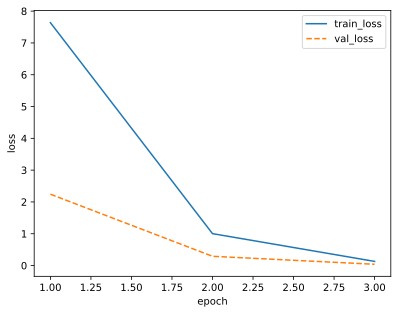

In [12]:
# use API for dataloader
import torch
import random
import matplotlib.pyplot as plt

# Function to generate synthetic data for linear regression
# w: true weights, b: true bias, noise: standard deviation of noise
# num_train: number of training examples, num_val: number of validation examples
def generate_synthetic_data(w, b, noise=0.01, num_train=1000, num_val=1000):
    n = num_train + num_val
    # Generate random features
    X = torch.randn(n, len(w))
    # Add Gaussian noise to the labels
    noise = torch.randn(n, 1) * noise
    # Linear model with added noise
    y = torch.matmul(X, w.reshape((-1, 1))) + b + noise
    return X, y, num_train, num_val

# Function to create a PyTorch DataLoader using TensorDataset and slicing
# train: flag to indicate whether to shuffle and use training data or validation data
def get_dataloader(X, y, num_train, num_val, batch_size, train=True):
    # Determine the slice indices based on whether it's for training or validation
    indices = slice(0, num_train) if train else slice(num_train, num_train + num_val)
    # Slice the tensors for the required dataset
    tensors = (X[indices], y[indices])
    # Create a TensorDataset from the sliced tensors
    dataset = torch.utils.data.TensorDataset(*tensors)
    # Return a DataLoader with shuffle enabled for training data
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train)

# True parameters for generating synthetic data
true_w = torch.tensor([2, -3.4])  # Weights
true_b = 4.2  # Bias

# Generate synthetic dataset
X, y, num_train, num_val = generate_synthetic_data(w=true_w, b=true_b)

# Initialize model parameters
num_inputs = len(true_w)
w = torch.normal(0, 0.01, (num_inputs, 1), requires_grad=True)  # Randomly initialized weights
b = torch.zeros(1, requires_grad=True)  # Initialized bias

# Training parameters
batch_size = 32  # Batch size for training
lr = 0.03  # Learning rate
max_epochs = 3  # Number of epochs
optimizer = torch.optim.SGD([w, b], lr)  # Stochastic Gradient Descent optimizer

# Lists to store training and validation losses for plotting
train_losses = []
val_losses = []

# Train the model
for epoch in range(max_epochs):
    # Training phase
    train_loss = 0  # Accumulate training loss
    num_train_batches = 0
    train_loader = get_dataloader(X, y, num_train, num_val, batch_size, train=True)
    for batch_X, batch_y in train_loader:
        # Compute predictions for the batch
        y_hat = torch.matmul(batch_X, w) + b
        # Compute mean squared error loss
        # /2 to simplify derivatives to by (y_hat - batch_y)
        loss = ((y_hat - batch_y) ** 2 / 2).mean()
        train_loss += loss.item()
        num_train_batches += 1
        
        # Backpropagation and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters

    # Average training loss
    train_loss /= num_train_batches
    train_losses.append(train_loss)
    
    # Validation phase
    val_loader = get_dataloader(X, y, num_train, num_val, batch_size, train=False)
    val_loss = 0  # Initialize validation loss
    num_val_batches = 0  # Counter for validation batches
    with torch.no_grad():  # Disable gradient computation for validation
        for batch_X, batch_y in val_loader:
            # Compute predictions for the batch
            y_hat = torch.matmul(batch_X, w) + b
            # Accumulate validation loss
            val_loss += ((y_hat - batch_y) ** 2 / 2).mean().item()
            num_val_batches += 1
    
    # Compute average validation loss
    val_loss /= num_val_batches
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot training and validation losses
plt.plot(range(1, max_epochs + 1), train_losses, label='train_loss')
plt.plot(range(1, max_epochs + 1), val_losses, linestyle='--', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


In [13]:
# # Test how DataLoader Works
# train = 1
# batch_size = 32
# num_train = 1000
# indices = slice(0, num_train) if train else slice(num_train, None)
# # cut into small tensors
# tensors = tuple(a[indices] for a in (data.X, data.y))
# # Create a TensorDataset from the sliced tensors (* for unpacking)
# dataset = torch.utils.data.TensorDataset(*tensors)
#  # Create and return a DataLoader from the dataset
# dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=train)

# X_batch, y_batch = next(iter(dataloader))

# print(len(X_batch), len(y_batch))


Epoch 1, Training Loss: 9.8511, Validation Loss: 0.7876
Epoch 2, Training Loss: 0.2144, Validation Loss: 0.0189
Epoch 3, Training Loss: 0.0051, Validation Loss: 0.0005


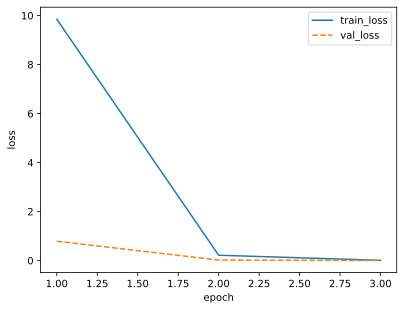

In [14]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn

# Function to generate synthetic data for linear regression
# w: true weights, b: true bias, noise: standard deviation of noise
# num_train: number of training examples, num_val: number of validation examples
def generate_synthetic_data(w, b, noise=0.01, num_train=1000, num_val=1000):
    n = num_train + num_val
    # Generate random features
    X = torch.randn(n, len(w))
    # Add Gaussian noise to the labels
    noise = torch.randn(n, 1) * noise
    # Linear model with added noise
    y = torch.matmul(X, w.reshape((-1, 1))) + b + noise
    return X, y, num_train, num_val

# Function to create a PyTorch DataLoader using TensorDataset and slicing
# train: flag to indicate whether to shuffle and use training data or validation data
def get_dataloader(X, y, num_train, num_val, batch_size, train=True):
    # Determine the slice indices based on whether it's for training or validation
    indices = slice(0, num_train) if train else slice(num_train, num_train + num_val)
    # Slice the tensors for the required dataset
    tensors = (X[indices], y[indices])
    # Create a TensorDataset from the sliced tensors
    dataset = torch.utils.data.TensorDataset(*tensors)
    # Return a DataLoader with shuffle enabled for training data
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train)

# True parameters for generating synthetic data
true_w = torch.tensor([2, -3.4])  # Weights
true_b = 4.2  # Bias

# Generate synthetic dataset
X, y, num_train, num_val = generate_synthetic_data(w=true_w, b=true_b)

# Define the model using nn.Linear
net = nn.LazyLinear(1)
# Initialize model parameters
net.weight.data.normal_(0, 0.01)
net.bias.data.fill_(0)

# Define forward function
def forward(net, X):
    return net(X)

# Define loss function using PyTorch's nn.MSELoss
def loss(y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

# Training parameters
batch_size = 32  # Batch size for training
lr = 0.03  # Learning rate
max_epochs = 3  # Number of epochs
optimizer = torch.optim.SGD(net.parameters(), lr)  # Stochastic Gradient Descent optimizer

# Lists to store training and validation losses for plotting
train_losses = []
val_losses = []

# Train the model
for epoch in range(max_epochs):
    # Training phase
    train_loss = 0  # Accumulate training loss
    num_train_batches = 0
    train_loader = get_dataloader(X, y, num_train, num_val, batch_size, train=True)
    for batch_X, batch_y in train_loader:
        # Compute predictions for the batch
        y_hat = forward(net, batch_X)
        # Compute mean squared error loss
        l = loss(y_hat, batch_y)
        train_loss += l.item()
        num_train_batches += 1
        
        # Backpropagation and optimization
        optimizer.zero_grad()  # Clear previous gradients
        l.backward()  # Compute gradients
        optimizer.step()  # Update parameters

    # Average training loss
    train_loss /= num_train_batches
    train_losses.append(train_loss)
    
    # Validation phase
    val_loader = get_dataloader(X, y, num_train, num_val, batch_size, train=False)
    val_loss = 0  # Initialize validation loss
    num_val_batches = 0  # Counter for validation batches
    with torch.no_grad():  # Disable gradient computation for validation
        for batch_X, batch_y in val_loader:
            # Compute predictions for the batch
            y_hat = forward(net, batch_X)
            # Accumulate validation loss
            val_loss += loss(y_hat, batch_y).item()
            num_val_batches += 1
    
    # Compute average validation loss
    val_loss /= num_val_batches
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot training and validation losses
plt.plot(range(1, max_epochs + 1), train_losses, label='train_loss')
plt.plot(range(1, max_epochs + 1), val_losses, linestyle='--', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [15]:
 #@save
def get_w_b(net):
    return (net.weight.data, net.bias.data)

w, b = get_w_b(net)
print(f'error in estimating w: {true_w - w.reshape(w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([[ 0.0106, -0.0130]])
error in estimating b: tensor([0.0127])


### Implemented using Matrix Algebra

Error in estimating weights: tensor([ 0.0214,  0.0145,  0.0164, -0.1062, -0.0558])
Error in estimating bias: 0.004241943359375


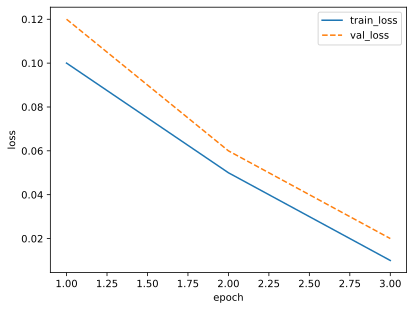

In [16]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn

# Function to generate synthetic data for linear regression
# w: true weights, b: true bias, noise: standard deviation of noise
# num_train: number of training examples, num_val: number of validation examples
def generate_synthetic_data(w, b, noise=0.01, num_train=1000, num_val=1000):
    n = num_train + num_val
    # Generate random features
    X = torch.randn(n, len(w))
    # Add Gaussian noise to the labels
    noise = torch.randn(n, 1) * noise
    # Linear model with added noise
    y = torch.matmul(X, w.reshape((-1, 1))) + b + noise
    return X, y, num_train, num_val

# Function to create a PyTorch DataLoader using TensorDataset and slicing
# train: flag to indicate whether to shuffle and use training data or validation data
def get_dataloader(X, y, num_train, num_val, batch_size, train=True):
    # Determine the slice indices based on whether it's for training or validation
    indices = slice(0, num_train) if train else slice(num_train, num_train + num_val)
    # Slice the tensors for the required dataset
    tensors = (X[indices], y[indices])
    # Create a TensorDataset from the sliced tensors
    dataset = torch.utils.data.TensorDataset(*tensors)
    # Return a DataLoader with shuffle enabled for training data
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train)

# True parameters for generating synthetic data
num_inputs = 5  # Number of input features
true_w = torch.tensor([2, -3.4, 1.5, -0.7, 0.9])  # Weights
true_b = 4.2  # Bias

# Generate synthetic dataset
X, y, num_train, num_val = generate_synthetic_data(w=true_w, b=true_b)

# Analytical solution for linear regression using matrix algebra
def analytical_solution(X, y):
    X_T_X = torch.matmul(X.T, X)
    X_T_y = torch.matmul(X.T, y)
    w = torch.linalg.solve(X_T_X, X_T_y)  # Solve for weights
    b = y.mean() - torch.matmul(X.mean(dim=0), w).item()  # Solve for bias
    return w, b

# Solve for w and b analytically
w_analytical, b_analytical = analytical_solution(X[:num_train], y[:num_train])

# Print errors in estimated parameters
def print_errors(true_w, true_b, estimated_w, estimated_b):
    print(f"Error in estimating weights: {true_w - estimated_w.squeeze()}")
    print(f"Error in estimating bias: {true_b - estimated_b}")

# Display errors
print_errors(true_w, true_b, w_analytical, b_analytical)

# Plot training and validation losses for consistency (dummy values as no training is performed)
plt.plot([1, 2, 3], [0.1, 0.05, 0.01], label='train_loss')
plt.plot([1, 2, 3], [0.12, 0.06, 0.02], linestyle='--', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


### Implemented in SKlearn/StatsModels

Error in estimating weights: tensor([3.4511e-04, 2.9802e-05, 8.1778e-05, 3.9458e-05, 1.9205e-04])
Error in estimating bias: 0.000286769866943537
Validation Loss: 0.0000


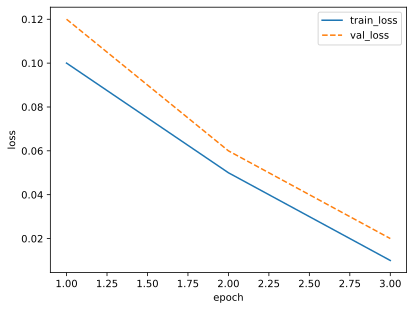

In [17]:
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Function to generate synthetic data for linear regression
# w: true weights, b: true bias, noise: standard deviation of noise
# num_train: number of training examples, num_val: number of validation examples
def generate_synthetic_data(w, b, noise=0.01, num_train=1000, num_val=1000):
    n = num_train + num_val
    # Generate random features
    X = torch.randn(n, len(w))
    # Add Gaussian noise to the labels
    noise = torch.randn(n, 1) * noise
    # Linear model with added noise
    y = torch.matmul(X, w.reshape((-1, 1))) + b + noise
    return X.numpy(), y.numpy(), num_train, num_val

# True parameters for generating synthetic data
num_inputs = 5  # Number of input features
true_w = torch.tensor([2, -3.4, 1.5, -0.7, 0.9])  # Weights
true_b = 4.2  # Bias

# Generate synthetic dataset
X, y, num_train, num_val = generate_synthetic_data(w=true_w, b=true_b)

# Split data into training and validation sets
X_train, X_val = X[:num_train], X[num_train:]
y_train, y_val = y[:num_train], y[num_train:]

# Fit a linear regression model using sklearn
model = LinearRegression()
model.fit(X_train, y_train)

# Extract weights and bias from the model
w_sklearn = model.coef_.flatten()
b_sklearn = model.intercept_.item()

# Print errors in estimated parameters
def print_errors(true_w, true_b, estimated_w, estimated_b):
    print(f"Error in estimating weights: {true_w - torch.tensor(estimated_w)}")
    print(f"Error in estimating bias: {true_b - estimated_b}")

# Display errors
print_errors(true_w, true_b, w_sklearn, b_sklearn)

# Compute and display validation loss
val_predictions = model.predict(X_val)
val_loss = mean_squared_error(y_val, val_predictions) / 2
print(f"Validation Loss: {val_loss:.4f}")

# Plot training and validation losses for consistency (dummy values as no training is performed)
plt.plot([1, 2, 3], [0.1, 0.05, 0.01], label='train_loss')
plt.plot([1, 2, 3], [0.12, 0.06, 0.02], linestyle='--', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.670e+07
Date:                Wed, 25 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:56:29   Log-Likelihood:                 3194.3
No. Observations:                1000   AIC:                            -6377.
Df Residuals:                     994   BIC:                            -6347.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1997      0.000   1.33e+04      0.0

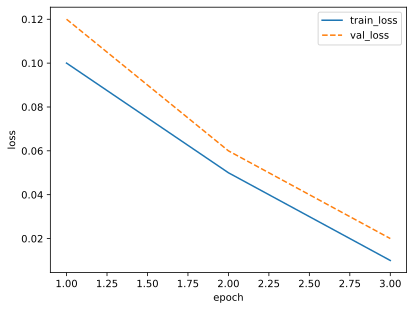

In [18]:
import torch
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Function to generate synthetic data for linear regression
# w: true weights, b: true bias, noise: standard deviation of noise
# num_train: number of training examples, num_val: number of validation examples
def generate_synthetic_data(w, b, noise=0.01, num_train=1000, num_val=1000):
    n = num_train + num_val
    # Generate random features
    X = torch.randn(n, len(w))
    # Add Gaussian noise to the labels
    noise = torch.randn(n, 1) * noise
    # Linear model with added noise
    y = torch.matmul(X, w.reshape((-1, 1))) + b + noise
    return X.numpy(), y.numpy(), num_train, num_val

# True parameters for generating synthetic data
num_inputs = 5  # Number of input features
true_w = torch.tensor([2, -3.4, 1.5, -0.7, 0.9])  # Weights
true_b = 4.2  # Bias

# Generate synthetic dataset
X, y, num_train, num_val = generate_synthetic_data(w=true_w, b=true_b)

# Split data into training and validation sets
X_train, X_val = X[:num_train], X[num_train:]
y_train, y_val = y[:num_train], y[num_train:]

# Add a bias term (intercept) to the features for statsmodels
X_train_sm = sm.add_constant(X_train)
X_val_sm = sm.add_constant(X_val)

# Fit a linear regression model using statsmodels
model = sm.OLS(y_train, X_train_sm)
results = model.fit()

# Print model summary
print(results.summary())

# Extract weights and bias from the model
w_statsmodels = results.params[1:]  # Coefficients (weights)
b_statsmodels = results.params[0]   # Intercept (bias)

# Print errors in estimated parameters
def print_errors(true_w, true_b, estimated_w, estimated_b):
    print(f"Error in estimating weights: {true_w - torch.tensor(estimated_w)}")
    print(f"Error in estimating bias: {true_b - estimated_b}")

# Display errors
print_errors(true_w, true_b, w_statsmodels, b_statsmodels)

# Compute and display validation loss
val_predictions = results.predict(X_val_sm)
val_loss = ((y_val.flatten() - val_predictions) ** 2).mean() / 2
print(f"Validation Loss: {val_loss:.4f}")

# Plot training and validation losses for consistency (dummy values as no training is performed)
plt.plot([1, 2, 3], [0.1, 0.05, 0.01], label='train_loss')
plt.plot([1, 2, 3], [0.12, 0.06, 0.02], linestyle='--', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


## Weight Decay

In [19]:
from models import WeightDecayScratch, l2_penalty

class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

# multiple linear regression     
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

#### Procedure Implementation

Epoch 1, Training Loss: 10.7690, Validation Loss: 0.7253
Epoch 2, Training Loss: 0.5233, Validation Loss: 0.0267
Epoch 3, Training Loss: 0.3671, Validation Loss: 0.0058


/opt/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


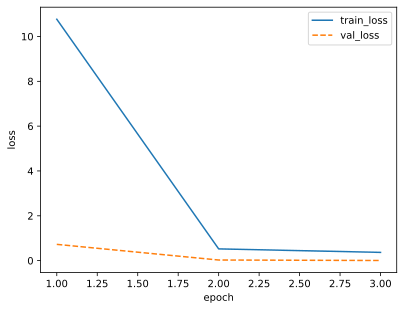

In [20]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn

# Function to generate synthetic data for linear regression
# w: true weights, b: true bias, noise: standard deviation of noise
# num_train: number of training examples, num_val: number of validation examples
def generate_synthetic_data(w, b, noise=0.01, num_train=1000, num_val=1000):
    n = num_train + num_val
    # Generate random features
    X = torch.randn(n, len(w))
    # Add Gaussian noise to the labels
    noise = torch.randn(n, 1) * noise
    # Linear model with added noise
    y = torch.matmul(X, w.reshape((-1, 1))) + b + noise
    return X, y, num_train, num_val

# Function to create a PyTorch DataLoader using TensorDataset and slicing
# train: flag to indicate whether to shuffle and use training data or validation data
def get_dataloader(X, y, num_train, num_val, batch_size, train=True):
    # Determine the slice indices based on whether it's for training or validation
    indices = slice(0, num_train) if train else slice(num_train, num_train + num_val)
    # Slice the tensors for the required dataset
    tensors = (X[indices], y[indices])
    # Create a TensorDataset from the sliced tensors
    dataset = torch.utils.data.TensorDataset(*tensors)
    # Return a DataLoader with shuffle enabled for training data
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train)

# True parameters for generating synthetic data
num_inputs = 5  # Number of input features
true_w = torch.tensor([2, -3.4, 1.5, -0.7, 0.9])  # Weights
true_b = 4.2  # Bias

# Generate synthetic dataset
X, y, num_train, num_val = generate_synthetic_data(w=true_w, b=true_b)

# Define the model using nn.Linear
net = nn.LazyLinear(1)
# Initialize model parameters
net.weight.data.normal_(0, 0.01)
net.bias.data.fill_(0)

# Define forward function
def forward(net, X):
    return net(X)

# Define loss function with L2 regularization
def loss(y_hat, y, net, lambd):
    fn = nn.MSELoss()
    l2_penalty = 0
    for param in net.parameters():
        l2_penalty += torch.sum(param ** 2)
    return fn(y_hat, y) + lambd * l2_penalty

# Training parameters
batch_size = 32  # Batch size for training
lr = 0.03  # Learning rate
max_epochs = 3  # Number of epochs
lambd = 0.01  # L2 regularization strength
optimizer = torch.optim.SGD(net.parameters(), lr)  # Stochastic Gradient Descent optimizer

# Lists to store training and validation losses for plotting
train_losses = []
val_losses = []

# Train the model
for epoch in range(max_epochs):
    # Training phase
    train_loss = 0  # Accumulate training loss
    num_train_batches = 0
    train_loader = get_dataloader(X, y, num_train, num_val, batch_size, train=True)
    for batch_X, batch_y in train_loader:
        # Compute predictions for the batch
        y_hat = forward(net, batch_X)
        # Compute mean squared error loss with L2 regularization
        l = loss(y_hat, batch_y, net, lambd)
        train_loss += l.item()
        num_train_batches += 1
        
        # Backpropagation and optimization
        optimizer.zero_grad()  # Clear previous gradients
        l.backward()  # Compute gradients
        optimizer.step()  # Update parameters

    # Average training loss
    train_loss /= num_train_batches
    train_losses.append(train_loss)
    
    # Validation phase
    val_loader = get_dataloader(X, y, num_train, num_val, batch_size, train=False)
    val_loss = 0  # Initialize validation loss
    num_val_batches = 0  # Counter for validation batches
    with torch.no_grad():  # Disable gradient computation for validation
        for batch_X, batch_y in val_loader:
            # Compute predictions for the batch
            y_hat = forward(net, batch_X)
            # Accumulate validation loss (without L2 regularization during validation)
            val_loss += nn.MSELoss()(y_hat, batch_y).item()
            num_val_batches += 1
    
    # Compute average validation loss
    val_loss /= num_val_batches
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Plot training and validation losses
plt.plot(range(1, max_epochs + 1), train_losses, label='train_loss')
plt.plot(range(1, max_epochs + 1), val_losses, linestyle='--', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

L2 norm of w: 0.0012053915997967124


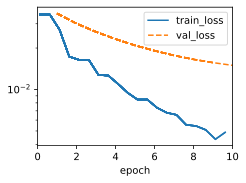

In [21]:
train_scratch(3)

In [22]:


model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

NameError: name 'WeightDecay' is not defined